In [24]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np
import pandas as pd
import h5py,os

import model_structure
import importlib
importlib.reload(model_structure)

import matplotlib as plt
import seaborn as sns
from sklearn.metrics import roc_curve
from progressbar import ProgressBar
from sklearn.metrics import auc
import matplotlib.pyplot as plt
datadir = '/mnt/1a18a49e-9a31-4dbf-accd-3fb8abbfab2d/brain_atac/data'

In [2]:
#5 output for basic, 21 for major, 
f = h5py.File(datadir+'/output_basic.h5','r')
x_test = f['test_seq']
y_test = f['test_label']
x_train = f['train_seq']
y_train = f['train_label']
x_valid = f['valid_seq']
y_valid = f['valid_label']
save_model = datadir+'/model/filtered_model.h5'

In [3]:
b_y_train= model_structure.filter_dataset(y_train[:,0],0.05)
b_y_test= model_structure.filter_dataset(y_test[:,0],0.05)
b_y_valid= model_structure.filter_dataset(y_valid[:,0],0.05)

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


In [4]:
model = model_structure.CNN_dense((4999,4),1)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4999, 4)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 4999, 32)          672       
_________________________________________________________________
batch_normalization (BatchNo (None, 4999, 32)          128       
_________________________________________________________________
activation (Activation)      (None, 4999, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4999, 32)          5152      
_________________________________________________________________
batch_normalization_1 (Batch (None, 4999, 32)          128       
_________________________________________________________________
activation_1 (Activation)    (None, 4999, 32)          0     

In [5]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                             min_delta=0, 
                                             patience=5, 
                                             verbose=1, 
                                             mode='min', 
                                             baseline=None, restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.5,
                                                 patience=5, 
                                                 min_lr=1e-7,
                                                 mode='min',
                                                 verbose=1)

checkpoint = tf.keras.callbacks.ModelCheckpoint(save_model, 
                                                monitor='val_loss', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='min')

In [6]:
training = model.fit(x_train[()],b_y_train,
                    epochs=200,
                    batch_size = 64,
                    callbacks = [earlystop,reduce_lr,checkpoint], 
                    validation_data = (x_valid[()],b_y_valid)
                    )

Train on 436419 samples, validate on 26708 samples
Epoch 1/200
436352/436419 [============================>.] - ETA: 0s - loss: 0.1185 - accuracy: 0.9729 - auroc: 0.7733 - aupr: 0.9902
Epoch 00001: val_loss improved from inf to 0.12143, saving model to /mnt/1a18a49e-9a31-4dbf-accd-3fb8abbfab2d/brain_atac/data/model/filtered_model.h5
436419/436419 [==============================] - 239s 548us/sample - loss: 0.1185 - accuracy: 0.9730 - auroc: 0.7733 - aupr: 0.9902 - val_loss: 0.1214 - val_accuracy: 0.9657 - val_auroc: 0.8462 - val_aupr: 0.9931
Epoch 2/200
436352/436419 [============================>.] - ETA: 0s - loss: 0.1027 - accuracy: 0.9734 - auroc: 0.8178 - aupr: 0.9929
Epoch 00002: val_loss did not improve from 0.12143
436419/436419 [==============================] - 229s 524us/sample - loss: 0.1027 - accuracy: 0.9734 - auroc: 0.8178 - aupr: 0.9929 - val_loss: 0.1715 - val_accuracy: 0.9632 - val_auroc: 0.8593 - val_aupr: 0.9939
Epoch 3/200
436416/436419 [===========================

In [9]:
#model = tf.keras.models.load_model(datadir+'/model/filtered_model.h5')
y_pred = model.predict(x_test[()])
#model.evaluate(x_test[()],b_y_test)

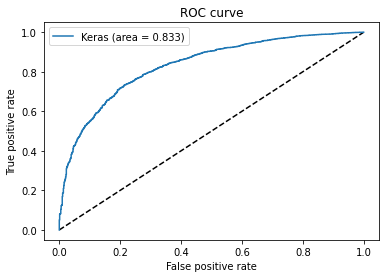

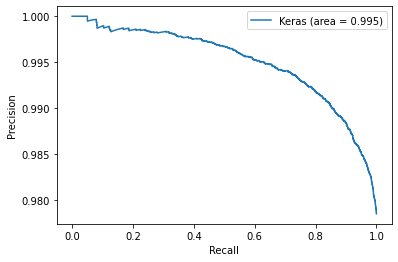

In [25]:
model_structure.curve_figure(y_pred,b_y_test,1)

In [22]:
y_test[()]

array([[0.        , 0.00222177, 0.00094967, 0.00081833, 0.00181159],
       [0.00174825, 0.00989699, 0.00949668, 0.00081833, 0.00362319],
       [0.        , 0.00080792, 0.00094967, 0.        , 0.0009058 ],
       ...,
       [0.0034965 , 0.00040396, 0.00094967, 0.00081833, 0.        ],
       [0.00174825, 0.00121188, 0.002849  , 0.        , 0.00181159],
       [0.0034965 , 0.00181781, 0.00094967, 0.        , 0.0009058 ]],
      dtype=float32)